# Model performance in production: all GB

This document contains the code used to compute performance scores of all the models used for the case of GB. It is the production version of [`explore_model_performance`](explore_model_performance).

In [1]:
import os, warnings
import pandas
import geopandas
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import tools_chip_prob_modelling as tools

data_p = '/home/jovyan/data/spatial_signatures/chip_probs/prod_model_outputs/'

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Compile preditions

For every pair of `(chipsize, arch)`, we have:

- 1 x unique geography
- 1 x set of true labels
- 5 x sets of predictions by different `(algo, variant)`

In each of these `(chipsize, arch)` blocks, we compile the data in a single table:

```
id | label | split | geometry | preds1 | preds2 | preds3 | preds4 | preds5
```

We then assemble all the tables in a single one, tagging each observation with the block they belong to.

In [15]:
ps = ! ls $data_p*_y_pred.pq
db = []
for chipsize in [8, 16, 32, 64]:
    for arch in ['bic', 'sic', 'mor']:
        db.append(tools.compile_chipsize_arch(chipsize, arch, ps))
db = pandas.concat(db)
db.iloc[:, 4:] = db.iloc[:, 4:].apply(
    lambda x: pandas.Categorical(x, categories=tools.class_names)
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2552961 entries, 1 to 94959
Data columns (total 9 columns):
 #   Column                                      Dtype   
---  ------                                      -----   
 0   geometry                                    geometry
 1   label                                       category
 2   split                                       object  
 3   chipsize_arch                               object  
 4   HistGradientBoostingClassifier_baseline-wx  category
 5   HistGradientBoostingClassifier_baseline     category
 6   logite_baseline-wx                          category
 7   logite_baseline                             category
 8   maxprob                                     category
dtypes: category(6), geometry(1), object(2)
memory usage: 92.5+ MB


## Non-spatial scores

In [45]:
def nss(sub_db):
    metas = {}
    models = sub_db.drop(
        columns=['label', 'split', 'chipsize_arch']
    ).columns
    for model in models:
        sub_train = sub_db.query('split == "ml_train"')
        sub_val = sub_db.query('split == "ml_val"')
        res = tools.build_perf(
            sub_train['label'],
            sub_train[model],
            sub_val['label'],
            sub_val[model],
            tools.class_names
        )
        metas[model] = deepcopy(res)
        del res
    return metas

In [46]:
%%time
metas = db[
    [c for c in db.columns if c != 'geometry']
].groupby('chipsize_arch').apply(nss)

metass = {}
for csarch in metas.index:
    for i in metas[csarch]:
        metass[f'{csarch}_{i}'] = metas[csarch][i]
metrics = pandas.Series(metass)

CPU times: user 4min 5s, sys: 1.34 s, total: 4min 7s
Wall time: 4min 3s


### Single scores

#### Summary stats

In [47]:
global_scores = []
for csam in metrics.index:
    global_scores.append(pandas.Series(
        {i.replace('perf_', '').replace('_val', ''): metrics[csam][i] for i in [
            'perf_kappa_val', 
            'perf_model_accuracy_val', 
            'perf_macro_f1_avg_val',
            'perf_macro_f1_w_val'
        ]},
        name=csam
    ))
global_scores = pandas.concat(
    global_scores, axis=1
).T
global_scores = global_scores.reset_index()
global_scores['chipsize'] = global_scores['index'].apply(lambda i: i.split('_')[0])
global_scores['arch'] = global_scores['index'].apply(lambda i: i.split('_')[1])
global_scores['model'] = global_scores['index'].apply(lambda i: '_'.join(i.split('_')[2:]))
global_scores = global_scores.set_index(
    ['arch', 'chipsize', 'model']
).drop(columns='index').sort_index()
global_scores

kappa  \
arch chipsize model                                                  
bic  16       HistGradientBoostingClassifier_baseline     0.275749   
              HistGradientBoostingClassifier_baseline-wx  0.361682   
              logite_baseline                             0.262573   
              logite_baseline-wx                          0.338490   
              maxprob                                     0.187177   
     32       HistGradientBoostingClassifier_baseline     0.315048   
              HistGradientBoostingClassifier_baseline-wx  0.402603   
              logite_baseline                             0.312078   
              logite_baseline-wx                          0.385497   
              maxprob                                     0.265221   
     64       HistGradientBoostingClassifier_baseline     0.427996   
              HistGradientBoostingClassifier_baseline-wx  0.526936   
              logite_baseline                             0.412455   
              logite_baseline-wx                          0.507401   
              maxprob                                     0.319494   
     8        HistGradientBoostingClassifier_baseline     0.246007   
              HistGradientBoostingClassifier_baseline-wx  0.280855   
              logite_baseline                             0.247200   
              logite_baseline-wx                          0.274374   
              maxprob                                     0.231938   
mor  16       HistGradientBoostingClassifier_baseline     0.254643   
              HistGradientBoostingClassifier_baseline-wx  0.269200   
              logite_baseline                             0.236548   
              logite_baseline-wx                          0.265856   
              maxprob                                     0.212690   
     32       HistGradientBoostingClassifier_baseline     0.439503   
              HistGradientBoostingClassifier_baseline-wx  0.338734   
              logite_baseline                             0.298071   
              logite_baseline-wx                          0.326147   
              maxprob                                     0.284674   
     64       HistGradientBoostingClassifier_baseline     0.681270   
              HistGradientBoostingClassifier_baseline-wx  0.589544   
              logite_baseline                             0.530732   
              logite_baseline-wx                          0.542034   
              maxprob                                     0.534811   
     8        HistGradientBoostingClassifier_baseline     0.234621   
              HistGradientBoostingClassifier_baseline-wx  0.273241   
              logite_baseline                             0.235271   
              logite_baseline-wx                          0.262831   
              maxprob                                     0.224009   
sic  16       HistGradientBoostingClassifier_baseline     0.302856   
              HistGradientBoostingClassifier_baseline-wx  0.414653   
              logite_baseline                             0.302232   
              logite_baseline-wx                          0.409139   
              maxprob                                     0.292997   
     32       HistGradientBoostingClassifier_baseline     0.333789   
              HistGradientBoostingClassifier_baseline-wx  0.444575   
              logite_baseline                             0.301006   
              logite_baseline-wx                          0.432935   
              maxprob                                     0.280813   
     64       HistGradientBoostingClassifier_baseline     0.364752   
              HistGradientBoostingClassifier_baseline-wx  0.466725   
              logite_baseline                             0.357339   
              logite_baseline-wx                          0.454303   
              maxprob                                     0.347160   
     8        HistGradientBoostingClassifier_baseline     0.277495   
 

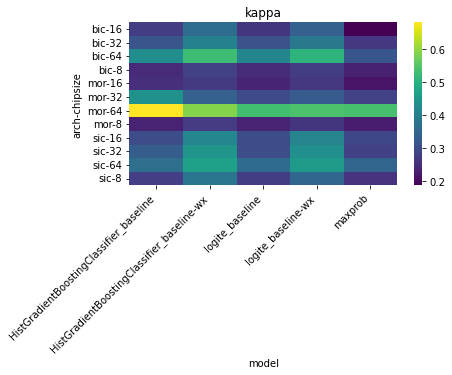

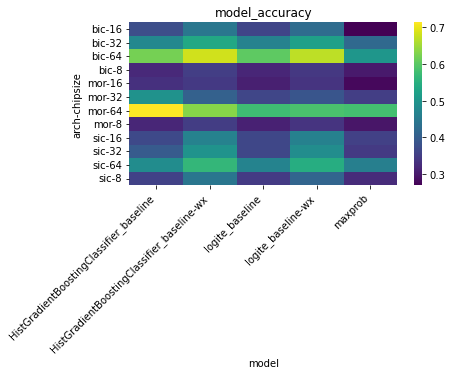

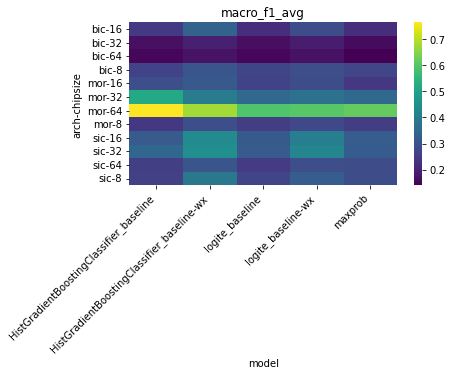

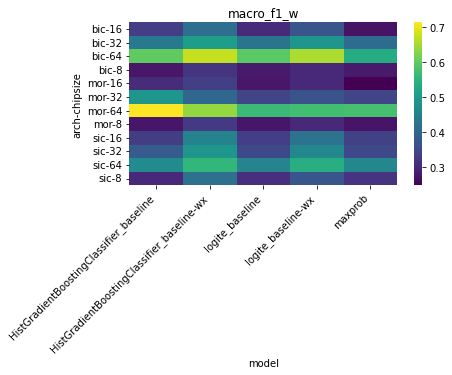

In [48]:
for score in global_scores:
    f, ax = plt.subplots(1, figsize=(6, 3))
    h = sns.heatmap(global_scores[score].unstack(), cmap='viridis', ax=ax)
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    h.set_title(score);

#### Regression models

In [49]:
mdb = global_scores.reset_index()
mdb['algo'] = mdb['model'].apply(lambda s: s.split('_')[0])
mdb['w'] = mdb['model'].str.contains('wx').astype(int)
m1 = sm.ols(
    'kappa ~ arch + chipsize + algo + w', mdb
).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  kappa   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     16.70
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           7.81e-12
Time:                        11:36:42   Log-Likelihood:                 89.416
No. Observations:                  60   AIC:                            -160.8
Df Residuals:                      51   BIC:                            -142.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2752      0.023     12.188      0.000       0.230       0.321
arch[T.mor]         0.0227      0.019      1.213      0.231      -0.015       0.060
arch[T.sic]         0.0232      0.019      1.240      0.221      -0.014       0.061
chipsize[T.32]      0.0516      0.022      2.390      0.021       0.008       0.095
chipsize[T.64]      0.1784      0.022      8.263      0.000       0.135       0.222
chipsize[T.8]      -0.0225      0.022     -1.040      0.303      -0.066       0.021
algo[T.logite]     -0.0245      0.017     -1.433      0.158      -0.059       0.010
algo[T.maxprob]    -0.0559      0.023     -2.477      0.017      -0.101      -0.011
w                   0.0572      0.017      3.350      0.002       0.023       0.091
==============================================================================
Omnibus:                       11.581   Durbin-Watson:                   1.390
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.580
Skew:                           0.745   Prob(JB):                     0.000682
Kurtosis:                       4.900   Cond. No.                         6.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
m2 = sm.ols(
    'model_accuracy ~ arch + chipsize + algo + w', mdb
).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         model_accuracy   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     31.10
Date:                Fri, 19 Aug 2022   Prob (F-statistic):           4.90e-17
Time:                        11:37:00   Log-Likelihood:                 99.933
No. Observations:                  60   AIC:                            -181.9
Df Residuals:                      51   BIC:                            -163.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3889      0.019     20.522      0.000       0.351       0.427
arch[T.mor]        -0.0357      0.016     -2.273      0.027      -0.067      -0.004
arch[T.sic]        -0.0247      0.016     -1.576      0.121      -0.056       0.007
chipsize[T.32]      0.0677      0.018      3.738      0.000       0.031       0.104
chipsize[T.64]      0.2140      0.018     11.808      0.000       0.178       0.250
chipsize[T.8]      -0.0245      0.018     -1.355      0.182      -0.061       0.012
algo[T.logite]     -0.0256      0.014     -1.789      0.080      -0.054       0.003
algo[T.maxprob]    -0.0606      0.019     -3.195      0.002      -0.099      -0.023
w                   0.0468      0.014      3.267      0.002       0.018       0.076
==============================================================================
Omnibus:                        1.963   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.375   Jarque-Bera (JB):                1.273
Skew:                           0.329   Prob(JB):                        0.529
Kurtosis:                       3.276   Cond. No.                         6.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Class-based scores

#### Confusion matrices

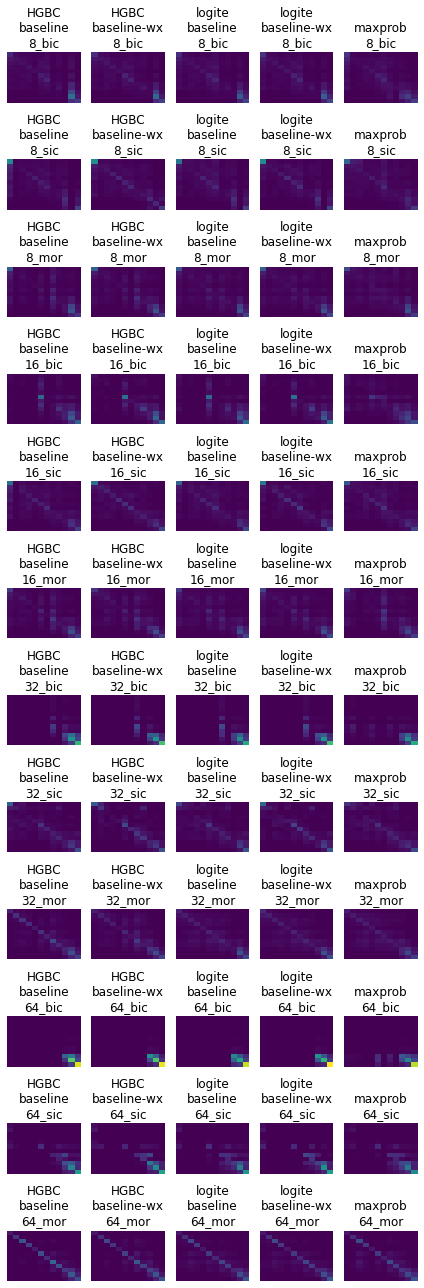

In [51]:
cms = []
for csam in metrics.index:
    csa = '_'.join(csam.split('_')[0:2])
    model = '_'.join(csam.split('_')[2:])
    cm = np.array(metrics[csam]['perf_confusion_val'])
    cm = cm * 100 / cm.sum()
    cms.append({'csa': csa, 'model': model, 'cm': cm})
cms = pandas.DataFrame(cms).pivot('csa', 'model', 'cm')

csa_order = [
    f'{cs}_{a}' for cs in [8, 16, 32, 64] for a in ['bic', 'sic', 'mor']
]

f, axs = plt.subplots(len(csa_order), cms.shape[1], figsize=(6, 18))
maxval = cms.applymap(np.max).values.max()
for csa in range(len(csa_order)):
    for model in range(cms.shape[1]):
        ax = axs[csa, model]
        tools.build_cm_plot(
            cms.loc[csa_order[csa], cms.columns[model]], 
            maxcount=maxval,
            cbar=False,
            ax=ax
        )
        model_title = cms.columns[model].replace(
            'HistGradientBoostingClassifier', 'HGBC'
        ).replace(
            '_', '\n'
        )
        t = f"{model_title}\n{csa_order[csa]}"
        ax.set_title(t)
plt.tight_layout()
plt.show()

#### Accuracy

In [57]:
from importlib import reload
reload(tools);

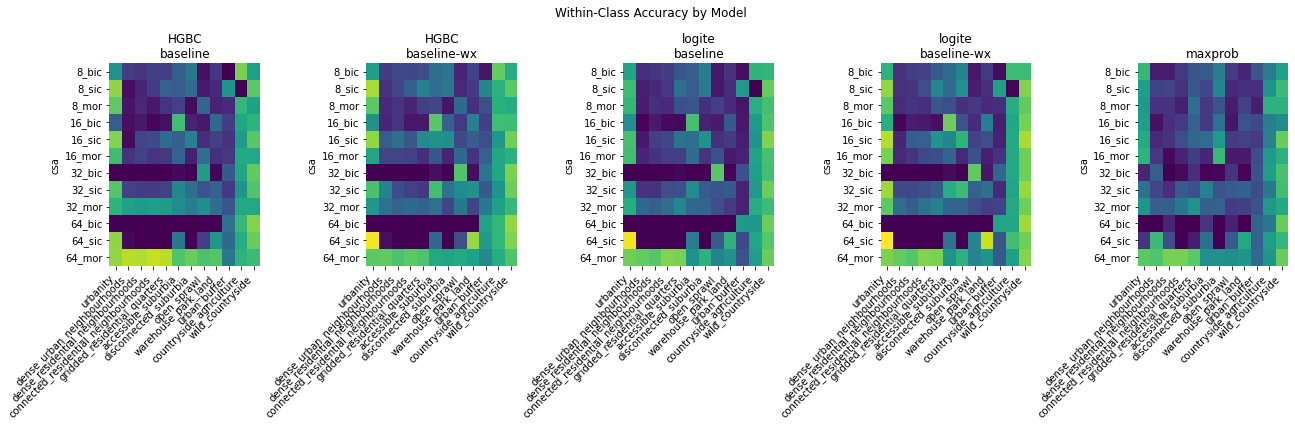

In [97]:
cba = []
for csam in metrics.index:
    csa = '_'.join(csam.split('_')[0:2])
    model = '_'.join(csam.split('_')[2:])
    scores = pandas.Series(
        metrics[csam]['perf_within_class_accuracy_val'],
        metrics[csam]['meta_class_names']
    )
    cba.append({'csa': csa, 'model': model, 'scores': scores})
cba = pandas.DataFrame(cba).pivot('csa', 'model', 'scores')

csa_order = [
    f'{cs}_{a}' for cs in [8, 16, 32, 64] for a in ['bic', 'sic', 'mor']
]

f, axs = plt.subplots(1, cba.shape[1], figsize=(18, 6))
maxval = cba.applymap(np.max).values.max()
for model in range(cba.shape[1]):
    ax = axs[model]
    h = sns.heatmap(
        pandas.DataFrame(
            cba[cba.columns[model]].tolist(), cba.index
        ).reindex(csa_order), 
        vmax=maxval,
        cbar=False,
        cmap='viridis',
        ax=ax
    )
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    model_title = cba.columns[model].replace(
        'HistGradientBoostingClassifier', 'HGBC'
    ).replace(
        '_', '\n'
    )
    ax.set_title(model_title)
plt.suptitle('Within-Class Accuracy by Model')
plt.tight_layout()
plt.show()

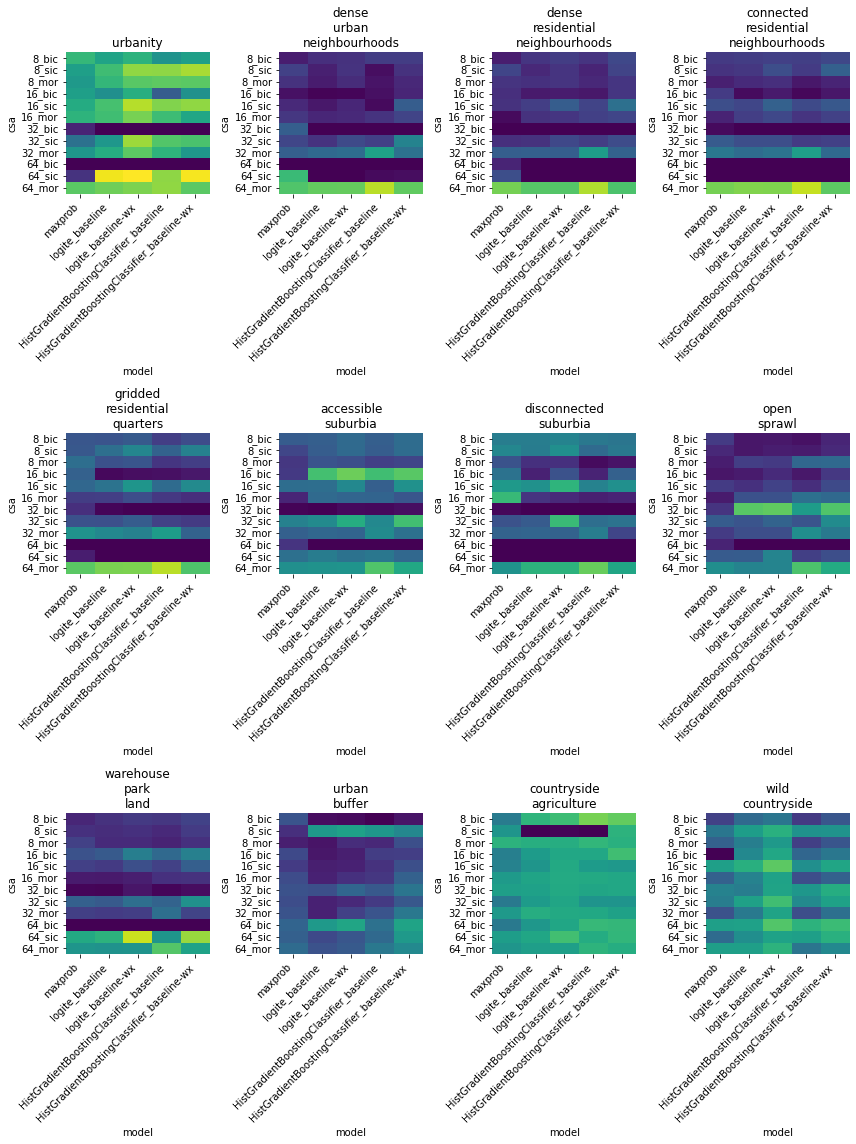

In [113]:
tmp = pandas.DataFrame(cba.stack().tolist(), cba.stack().index)
f, axs = plt.subplots(3, 4, figsize=(12, 16))
axs = axs.flatten()
models_order = [
    'maxprob', 
    'logite_baseline', 
    'logite_baseline-wx', 
    'HistGradientBoostingClassifier_baseline', 
    'HistGradientBoostingClassifier_baseline-wx'
]
maxval = tmp.values.max()
for i, sig in enumerate(tmp):
    tab = tmp[sig].unstack().reindex(index=csa_order, columns=models_order)
    h = sns.heatmap(
        tab,
        vmax=maxval,
        cbar=False,
        cmap='viridis',
        ax=axs[i]
    )
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    axs[i].set_title(sig.replace('_', '\n'))
plt.tight_layout()
plt.show()

## Spatial scores

- [ ] Moran
- [ ] Joint Counts
- [ ] Ripley's G
- [ ] Ripley's F

---

# Deprecated

Metric computation has been tested in `dask` but there are inconsistencies and thus we are putting it aside (the performance boost is of about half the time on a multi-core machine).

In [4]:
from dask import dataframe as ddf
from dask.distributed import Client, LocalCluster

client = Client(LocalCluster(n_workers=8))

2022-08-19 10:57:49,131 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/signature_ai/ai_experiments/dask-worker-space/worker-tu3w7x7h', purging
2022-08-19 10:57:49,132 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/signature_ai/ai_experiments/dask-worker-space/worker-vfs1_95e', purging
2022-08-19 10:57:49,132 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/signature_ai/ai_experiments/dask-worker-space/worker-zz13h2g1', purging


In [ ]:
client.restart()

In [18]:
%%time
ddb = ddf.from_pandas(
    db[[c for c in db.columns if c != 'geometry']], npartitions=16
)

metas = ddb.groupby('chipsize_arch').apply(nss, meta=object).compute()

metass = {}
for csarch in metas.index:
    for i in metas[csarch]:
        metass[f'{csarch}_{i}'] = metas[csarch][i]
metrics = pandas.Series(metass)

/opt/conda/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


CPU times: user 12 s, sys: 1.45 s, total: 13.4 s
Wall time: 2min 20s
